<a href="https://colab.research.google.com/github/h0mayoun/NetSwitch/blob/main/DSpace_DAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing dagviz library to use for visualizations.

In [ ]:
!pip install dagviz

import dagviz
from dagviz import render_svg
from dagviz.style.metro import svg_renderer, StyleConfig
from IPython.display import HTML

Importing required Python libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx

Defining simple functions to perform measurements and manipulations on binary adjacency matrices of graphs.

In [ ]:
def degree_seq(adj):
    '''Returns the degree sequence of a graph from its adjacency matrix.'''
    return np.sum(adj, axis=0)

def assortativity_coeff(adj):
    '''Calculates the assortativity coefficient for a graph
    from its binary adjacncy matrix.
    Calculations based on [PHYSICAL REVIEW E 84, 047101 (2011)].'''
    n = len(adj)
    m = np.sum(adj)/2.0
    deg = degree_seq(adj)
    M2, di1, di2 = 0, 0, 0
    for i in range(n-1):
        for j in range(i+1, n):
            if adj[i, j] == 1:
                M2 += deg[i] * deg[j]
                di1 += (deg[i] + deg[j])/2.0
                di2 += (deg[i]**2 + deg[j]**2)/2.0
    di1 = (di1/m) ** 2
    di2 /= m
    M2 /= m
    return (M2 - di1)/(di2 - di1)

def switch_4e(adj, e1, e2, e3, e4):
    mat = np.copy(adj)
    mat[e1[0], e1[1]], mat[e1[1], e1[0]], mat[e2[0], e2[1]], mat[e2[1], e2[0]] = 0, 0, 0, 0
    mat[e3[0], e3[1]], mat[e3[1], e3[0]], mat[e4[0], e4[1]], mat[e4[1], e4[0]] = 1, 1, 1, 1
    return mat

def switch_checkerboard(adj, i, j, k, l):
    mat = np.copy(adj)
    mat[i, k], mat[k, i], mat[j, k], mat[k, j] = 1-mat[i, k], 1-mat[k, i], 1-mat[j, k], 1-mat[k, j]
    mat[i, l], mat[l, i], mat[j, l], mat[l, j] = 1-mat[i, l], 1-mat[l, i], 1-mat[j, l], 1-mat[l, j]
    return mat

def is_checkerboard(ik, il, jk, jl):
    if ik == jl and il == jk and ik == 1-jk:
        return True
    else:
        return False

def find_adj(adj, mat_list):
    for i in range(len(mat_list)):
        if np.array_equal(adj, mat_list[i]):
            return i
    return -1

def all_next_switches_XBS(adj):
    adj_r = assortativity_coeff(adj)
    next_swt = []
    swt_type = []
    edgeIdxs = np.where(adj==1)
    edgeIdxs = [(edgeIdxs[0][i], edgeIdxs[1][i]) for i in range(len(edgeIdxs[0])) if edgeIdxs[0][i]<edgeIdxs[1][i]]
    for e1_idx in range(len(edgeIdxs)-1):
        for e2_idx in range(e1_idx+1, len(edgeIdxs)):
            e1, e2 = edgeIdxs[e1_idx], edgeIdxs[e2_idx]
            if len(set(e1+e2)) != 4:
                continue
            swt_options = [(e1[0], e2[0], e1[1], e2[1]), (e1[0], e2[1], e1[1], e2[0])]
            for opt in swt_options:
                if (adj[opt[0], opt[1]] == 1) or (adj[opt[2], opt[3]] == 1):
                    continue
                new_adj = switch_4e(adj, e1, e2, (opt[0], opt[1]), (opt[2], opt[3]))
                new_r =  assortativity_coeff(new_adj)
                if adj_r < new_r:
                    swt_type.append(True)
                elif adj_r > new_r:
                    swt_type.append(False)
                else:
                    if (opt[0] * opt[1] + opt[2]* opt[3]) - (e1[0] * e1[1] + e2[0] * e2[1]) > 0:
                        swt_type.append(True)
                    else:
                        swt_type.append(False)
                next_swt.append(new_adj)
    return next_swt, swt_type

def all_next_switches(adj):
    adj_r = assortativity_coeff(adj)
    n = len(adj)
    next_swt = []
    swt_type = []
    for row1 in range(n-1):
        for row2 in range(row1+1, n):
            for col1 in range(row1+1, n-1):
                if row2 == col1:
                    continue
                for col2 in range(col1+1, n):
                    if row2 == col2:
                        continue
                    if is_checkerboard(adj[row1, col1], adj[row1, col2], adj[row2, col1], adj[row2, col2]):
                        new_adj = switch_checkerboard(adj, row1, row2, col1, col2)
                        new_r =  assortativity_coeff(new_adj)
                        if adj[row1, col1] == 0:
                            swt_type.append(True)
                        else:
                            swt_type.append(False)
                        next_swt.append(new_adj)
    return next_swt, swt_type

def generate_switch_dag(adj):
    '''This function generates every graph in the degree-sequence space of the
    input adjacency matrix.
    The output is a set of adjacency matrices reachable from each other by one
    or more checkerboard switchings.
    The function returns arcs between graphs, representing switches that produce
    the target graph by an 'assortative' switch on the source graph.
    '''
    d_space = []
    d_space_arcs = []
    d_space_r = []
    d_space.append(adj)
    d_space_r.append(assortativity_coeff(adj))
    d_space_pointer = 0

    while d_space_pointer < len(d_space):
        nxt_swts, nxt_arcs = all_next_switches(d_space[d_space_pointer])
        for nxtswt_idx in range(len(nxt_swts)):
            nxt_swt = nxt_swts[nxtswt_idx]
            dspace_adj_index = find_adj(nxt_swt, d_space)
            if dspace_adj_index == -1:
                d_space.append(nxt_swt)
                d_space_r.append(deg_assortativity(nxt_swt))
                dspace_adj_index = len(d_space)-1
            if nxt_arcs[nxtswt_idx]:
                if (d_space_pointer, dspace_adj_index) not in d_space_arcs:
                    d_space_arcs.append((d_space_pointer, dspace_adj_index))
            else:
                if (dspace_adj_index, d_space_pointer) not in d_space_arcs:
                    d_space_arcs.append((dspace_adj_index, d_space_pointer))
        d_space_pointer += 1

    # SORTING the output according to the assortativity of the graphs
    sorted_arc_idxs = np.argsort(d_space_r)
    d_space = [d_space[idx] for idx in sorted_arc_idxs]
    d_space_r = [d_space_r[idx] for idx in sorted_arc_idxs]
    arc_sort_dict = {i:np.where(sorted_arc_idxs == i)[0][0] for i in sorted_arc_idxs}
    for arc_idx in range(len(d_space_arcs)):
        d_space_arcs[arc_idx] = (arc_sort_dict[d_space_arcs[arc_idx][0]], arc_sort_dict[d_space_arcs[arc_idx][1]])
    d_space_arcs.sort()
    #d_space_r, d_space, d_space_arcs = (list(lst) for lst in zip(*sorted(zip(d_space_r, d_space, d_space_arcs))))

    return d_space, d_space_arcs, d_space_r


<Figure size 1000x1000 with 0 Axes>

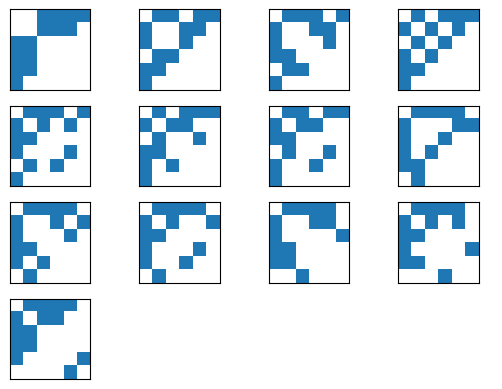

In [108]:
# Example small adjacency matrices for visualization of switch DAG
A = np.array([[0, 0, 1, 1, 1, 1, 0],
              [0, 0, 1, 1, 0, 0, 1],
              [1, 1, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0]])

A = np.array([[0, 0, 1, 1, 1, 1],
              [0, 0, 1, 1, 1, 0],
              [1, 1, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0]])

d_space, d_space_arcs, d_space_r = generate_switch_dag(A)

'''
    In the block below: Render, show, and save an SVG image
    depicting the resulting DAG,
    i.e. the graph of all switches in the degree sequence space.
'''
G = nx.DiGraph()
for i in range(len(d_space)):
    G.add_node(f"{i}")
for e in d_space_arcs:
    G.add_edge(f"{e[0]}", f"{e[1]}")
dagviz.Metro(G)
r = dagviz.render_svg(G, style=svg_renderer(StyleConfig(label_arrow_dash_array=0, label_font_size=0, scale=20, node_radius=0, arc_radius=25)))
with open("DAG.svg", "wt") as fs:
    fs.write(r)
display(HTML(render_svg(G)))

'''
    ALL MATRICES belonging to the d-space are plotted here,
    with the order following the indices shown on the DAG
    visualized above.
'''
cmap = colors.ListedColormap(['white', 'tab:blue'])
plot_dim = int(np.ceil(np.log2(len(d_space))))
fig = plt.figure(layout='constrained', figsize=(10, 10))
fig, axes = plt.subplots(plot_dim, plot_dim, sharex=True, sharey=True)
for x in range(plot_dim):
    for y in range(plot_dim):
        plot_idx = x * plot_dim + y
        if plot_idx < len(d_space):
            axes[x][y].imshow(d_space[plot_idx], cmap=cmap)
            axes[x][y].set_xticks([])
            axes[x][y].set_yticks([])
        else:
            axes[x][y].axis('off')
plt.show()

In [ ]:
# for mat_id in range(len(d_space)):
#     mat = d_space[mat_id]
#     plt.figure()
#     cmap = colors.ListedColormap(['white', 'tab:blue'])
#     plt.imshow(mat, cmap=cmap)
#     plt.xticks([])
#     plt.yticks([])
#     #plt.tight_layout()
#     plt.gca().set_axis_off()
#     plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
#     plt.margins(0, 0)
#     plt.gca().xaxis.set_major_locator(plt.NullLocator())
#     plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     #plt.savefig(f"filename.png", transparent=True, bbox_inches="tight", pad_inches=0)
#     plt.savefig('mat_'+str(mat_id)+'_'+str(round(deg_assortativity(mat), 4))+'.pdf', format='pdf', transparent=True, bbox_inches="tight", pad_inches=0)


In [ ]:
for mat_id in range(len(d_space)):
    mat = d_space[mat_id]
    plt.figure()
    cmap = colors.ListedColormap(['white', 'tab:blue'])
    plt.imshow(mat, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    #plt.tight_layout()
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    #plt.savefig(f"filename.png", transparent=True, bbox_inches="tight", pad_inches=0)
    plt.savefig('mat_'+str(mat_id)+'_'+str(round(deg_assortativity(mat), 4))+'.pdf', format='pdf', transparent=True, bbox_inches="tight", pad_inches=0)
print(d_space_r)
m = np.sum(A)/2.0
sort_idxes = np.argsort(d_space_r)
for idx in sort_idxes:
    print(idx, d_space_r[idx])

In [ ]:
# plt.gca().set_axis_off()
# plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
# plt.margins(0, 0)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.savefig(f"filename.png", transparent=True, bbox_inches="tight", pad_inches=0)
# plt.cla()